In [19]:
!pip install -U scikit-learn
!pip install gensim nltk
!pip install scikit-learn
!pip install transformers torch

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no 

In [20]:
import os
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim.downloader as api
import numpy as np


# use pretained word embedding model
word2vec = api.load('word2vec-google-news-300')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malickgaye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malickgaye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import random

In [37]:
def load_data_from_files(directory):
    texts = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                for line in file:
                    # Split each line into text and label using the tab character '\t'
                    text, label = line.rsplit('\t', 1)
                    texts.append(text)
                    labels.append(int(label.strip()))
    return texts, labels
directory = '/Users/malickgaye/github/machine_learning/sentiment+labelled+sentences/sentiment_labelled_sentences'
texts, labels = load_data_from_files(directory)
print(len(texts), len(labels))

3000 3000


In [38]:
# shuffle and split the dataset
'''
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)
split_ratio = 0.8 
split_index = int(len(texts) * split_ratio)
train_data, test_data = texts[:split_index], texts[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]
'''

'\ncombined = list(zip(texts, labels))\nrandom.shuffle(combined)\ntexts, labels = zip(*combined)\nsplit_ratio = 0.8 \nsplit_index = int(len(texts) * split_ratio)\ntrain_data, test_data = texts[:split_index], texts[split_index:]\ntrain_labels, test_labels = labels[:split_index], labels[split_index:]\n'

In [39]:
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Convert to lowercase
    text = text.lower()
    return text

In [40]:
# clear inexplicable characters and tokenize the sentence
texts_clean = [preprocess_text(text) for text in texts]
tokens = [word_tokenize(text) for text in texts_clean]

In [41]:
# word embedding
def embedding_sentence(model, sentence_token, maxSentenceLen = None, padding = False):
  vectors = np.array([model[word] for word in sentence_token if word in model.key_to_index])
  # guarantee dimension alignment even if vectors is empty
  vectors = np.zeros((0, model.vector_size)) if len(vectors) == 0 else vectors
  if padding:
    pad_num = maxSentenceLen - len(vectors)
    zero_rows = np.zeros((pad_num, model.vector_size))
    return np.vstack((vectors, zero_rows))
  else:
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(model.vector_size)
embedded_sentence = np.array([embedding_sentence(word2vec, sentence_token) for sentence_token in tokens])

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embedded_sentence, torch.tensor(labels), test_size=0.2, random_state=42)
print(len(X_train), len(X_test))


2400 600


(2400, 300)
(2400, 300)
Explained variance by the first 3 components: 15.22%


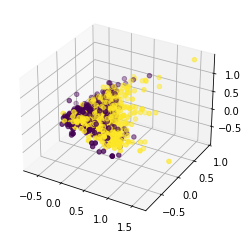

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA()
print(X_train.shape)
X_train_pca =pca.fit_transform(X_train)
print(X_train_pca.shape)
#plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, alpha = 0.4)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c = y_train)

explained_var_ratio = pca.explained_variance_ratio_
cumulative_variance = np.sum(explained_var_ratio[:3])

print("Explained variance by the first {} components: {:.2f}%".format(3, cumulative_variance * 100))

# attempt to use PCA to reduce dimension
# considering the eigenvalue distirbution is quite uniform, this approach doesn't work effectively

In [44]:
# standardize the data
class Standardizer:
  def __init__(self, X_train, axis= 0) -> None:
    '''
    trainX : N * D / N * L * D
    '''
    self.mean = np.mean(X_train, axis = axis)
    self.std = np.std(X_train, axis = axis)

  def transform(self, X):
    return (X - self.mean) / self.std

standardizer = Standardizer(X_train)
X_train_sd = standardizer.transform(X_train)
X_test_sd = standardizer.transform(X_test)

In [45]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validation(model, X, y, n_splits = 5):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  train_scores = []
  val_scores = []

  for train_index, val_index in kf.split(X):
    # Clone the model to ensure a fresh model is used for each fold
    cloned_model = clone(model)
    # Split the data into training and testing sets for the current fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    cloned_model.fit(X_train, y_train)
    val_scores.append(cloned_model.score(X_val, y_val))
    train_scores.append(cloned_model.score(X_train, y_train))
  return np.mean(val_scores)

def find_best_model(model_class, validation_func, param_grid, X, y):
  best_model, best_param = None, None
  best_score = 0
  for params in param_grid:
    model = model_class(**params)
    score = validation_func(model, X, y)
    if score > best_score:
      best_model = model
      best_score = score
      best_param = params
  return best_model, best_score, best_param


In [46]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


param_grid = [
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 5.0, 'kernel': 'linear'},
    {'C': 10.0, 'kernel': 'linear'},
    {'C': 100.0, 'kernel': 'linear'},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 'scale'}, 
    {'C': 100.0, 'kernel': 'rbf', 'gamma': 'auto'}, 
]
svm_model, val_score, best_param = find_best_model(SVC, cross_validation, param_grid, X_train, y_train)
svm_model.fit(X_train_sd, y_train)
print("best SVC param:", best_param,
    "validation score:", val_score,
      "train score:", svm_model.score(X_train_sd, y_train),
      "test score:", svm_model.score(X_test_sd, y_test))

best SVC param: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'} validation score: 0.8425 train score: 0.9295833333333333 test score: 0.86


In [47]:
param_grid = [
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 300},
    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 400},
    {'C': 100, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 600},
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 200},
    {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 400},
    {'C': 100, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 600},
    {'C': 0.01, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5, 'max_iter': 100},
    {'C': 1, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5, 'max_iter': 400},
    {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5, 'max_iter': 600},
]


log_model, val_score, best_param = find_best_model(LogisticRegression, cross_validation, param_grid, X_train, y_train)
log_model.fit(X_train_sd, y_train)
print("best logistic regression param:", best_param,
    "validation score:", val_score,
      "train score:", log_model.score(X_train_sd, y_train),
      "test score:", log_model.score(X_test_sd, y_test))

/Users/malickgaye/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/malickgaye/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/malickgaye/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/malickgaye/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/malickgaye/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best logistic regression param: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 400} validation score: 0.83625 train score: 0.8879166666666667 test score: 0.8516666666666667


In [48]:
maxSentenceLen = 0
for token in tokens:
  maxSentenceLen = max(maxSentenceLen, len(token))
print("max sentence lenngth:", maxSentenceLen)

embedded_sentence_padding = np.array([embedding_sentence(word2vec, sentence_token, maxSentenceLen, True) for sentence_token in tokens])
print("shape of embedded sentence with padding:", embedded_sentence_padding.shape)

X_train, X_test, y_train, y_test = train_test_split(embedded_sentence_padding, torch.tensor(labels), test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

'''
CNN_sd = Standardizer(X_train)
X_train_sd2 = CNN_sd.transform(X_train)
X_test_sd2 = CNN_sd.transform(X_test)
'''

def toCNNData(TrainData):
  '''
  N : sample number, 
  L : sentence length after padding, 
  D : embedding dimension
  transform N * L * D to N * D * L * 1, where D is used as channel number
  '''
  return torch.tensor(TrainData, dtype=torch.float32).unsqueeze(3).permute(0, 2, 1, 3)

standardizer_CNN = Standardizer(X_train, axis = (0, 1))
X_train_sd2 = toCNNData(standardizer.transform(X_train))
X_test_sd2 = toCNNData(standardizer.transform(X_test))


print(X_train_sd2.shape)


max sentence lenngth: 71
shape of embedded sentence with padding: (3000, 71, 300)
2400 600
torch.Size([2400, 300, 71, 1])


In [49]:
class CNN(nn.Module):
  """
  CNN model for hand gesture recognition.
  """
  def __init__(self, L, D):
    """
    Initializes the CNN model layers.
    """
    # input shape: D * L * 1
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=D, out_channels=4, kernel_size=(3,1))
    self.conv2 = nn.Conv2d(4, 8, kernel_size=(4,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=2)
    self.conv3 = nn.Conv2d(8, 16, kernel_size=(3,1))

    self.dropout = nn.Dropout(0.3)
    # output shape after conv3: 32 * ((L-2)//2-3) * 1
    self.out_shape = ((L-2- 3)//2-2) * 1 * 16
    self.fc1 = nn.Linear(self.out_shape, 16)
    self.fc2 = nn.Linear(16, 2)

  def forward(self, x):
    """
    Forward pass of the CNN model.
    """
    x = F.relu(self.conv1(x))
    x = self.dropout(x)
    x = F.relu(self.conv2(x))
    
    x = self.pool(x)
    x = F.relu(self.conv3(x))

    x = x.view(-1, self.out_shape)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def score(self, X, y):
    output = self.forward(X)
    preds = torch.argmax(output, dim = 1)
    return (preds == y).sum() / len(y)

In [50]:
from torch import optim
import copy
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_sd2, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

CNN_model = CNN(maxSentenceLen, word2vec.vector_size)

def model_evaluation(model, X_train, y_train, X_test, y_test):
  optimizer = optim.Adam(model.parameters(), lr=5e-4)
  loss_fn = nn.CrossEntropyLoss()
  print(X_train_sd2.shape)

  train_scores, test_scores = [], []
  for epoch in range(15):
    model.train()
    for train, label in train_loader:
      optimizer.zero_grad()
      outputs = CNN_model(train)
      loss = loss_fn(outputs, label)
      loss.backward()
      optimizer.step()

    model.eval()
    print("Train score:", model.score(X_train, y_train), "Test score:", model.score(X_test, y_test))
    train_scores += [model.score(X_train, y_train).item()]
    test_scores += [model.score(X_test, y_test).item()]

  return train_scores, test_scores


train_scores, test_scores = model_evaluation(CNN_model, X_train_sd2, y_train, X_test_sd2, y_test)

torch.Size([2400, 300, 71, 1])
Train score: tensor(0.6954) Test score: tensor(0.6850)
Train score: tensor(0.8300) Test score: tensor(0.8100)
Train score: tensor(0.8750) Test score: tensor(0.8383)
Train score: tensor(0.8946) Test score: tensor(0.8467)
Train score: tensor(0.9046) Test score: tensor(0.8567)
Train score: tensor(0.9046) Test score: tensor(0.8450)
Train score: tensor(0.9267) Test score: tensor(0.8550)
Train score: tensor(0.9271) Test score: tensor(0.8650)
Train score: tensor(0.9392) Test score: tensor(0.8550)
Train score: tensor(0.9438) Test score: tensor(0.8550)
Train score: tensor(0.9475) Test score: tensor(0.8567)
Train score: tensor(0.9433) Test score: tensor(0.8533)
Train score: tensor(0.9596) Test score: tensor(0.8583)
Train score: tensor(0.9571) Test score: tensor(0.8500)
Train score: tensor(0.9575) Test score: tensor(0.8483)


### Transfer Learning from Pre-trained Bert Model

In [51]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization for train set
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
train_labels_tensor = torch.tensor(train_labels)

# Tokenization for test set
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']
test_labels_tensor = torch.tensor(test_labels)

# Define PyTorch dataset classes
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create train and test datasets
train_dataset = CustomDataset(train_input_ids, train_attention_mask, train_labels_tensor)
test_dataset = CustomDataset(test_input_ids, test_attention_mask, test_labels_tensor)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [52]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [53]:
from transformers import BertModel


class CustomBERTModel(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Freeze the parameters of the pre-trained BERT model
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits
        
        return logits


In [54]:
import torch
from torch.optim import Adam
from torch import nn

bertModel = CustomBERTModel(num_labels=2)
optimizer = Adam(bertModel.classifier.parameters(), lr=1e-3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [55]:
def train(model, dataloader, optimizer, epochs=5):
    model.train() 
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            loss, logits = model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")
        losses += [average_loss]

    return losses


In [56]:
def evaluate(model, dataloader):
    model.eval() 
    total_loss = 0
    correct_predictions = 0

    losses, accuracies = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            loss, logits = model(input_ids, attention_mask, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    print(f"Test Loss: {average_loss}, Accuracy: {accuracy}")
    losses += [average_loss]
    accuracies += [accuracy]

    return losses, accuracies


In [58]:
# Train the model
train_loss_bert = train(bertModel, train_dataloader, optimizer, epochs=30)

# Evaluate the model on the test dataset
evaluation_losses_bert, accuracies_bert = evaluate(bertModel, test_dataloader)


Epoch 1/30, Loss: 0.6488943572280308
Epoch 2/30, Loss: 0.5393537078828862


### Generalizability

In [ ]:
gen_texts, gen_labels = load_data_from_files("generalizability")
print(len(gen_texts), len(gen_labels))

200 200


In [ ]:
# Evaluate Transfer Learning Model Generalizability

gen_encodings = tokenizer(gen_texts, truncation=True, padding=True, max_length=256, return_tensors='pt')
gen_input_ids = gen_encodings['input_ids']
gen_attention_mask = gen_encodings['attention_mask']
gen_labels_tensor = torch.tensor(gen_labels)
gen_dataset = CustomDataset(gen_input_ids, gen_attention_mask, gen_labels_tensor)

gen_dataloader = DataLoader(gen_dataset, batch_size=2, shuffle=False)
gen_losses_bert, gen_accuracies_bert = evaluate(bertModel, gen_dataloader)

Test Loss: 0.5111124333101906, Accuracy: 0.81


In [47]:
# Preprocess for other models

gen_texts_clean = [preprocess_text(gen_text) for gen_text in gen_texts]
gen_tokens = [word_tokenize(gen_text) for gen_text in gen_texts_clean]
embedded_sentence = np.array([embedding_sentence(word2vec, sentence_token) for sentence_token in gen_tokens])
gen_X = torch.tensor(embedded_sentence)
gen_y = torch.tensor(gen_labels)

In [52]:
# Evaluate Logistic Regression/SVM Generalizability
gen_X_sd = standardizer.transform(gen_X)

print("Logistic Regression Accuracy:", log_model.score(gen_X_sd, gen_y))
print("SVM Accuracy:", svm_model.score(gen_X_sd, gen_y))

Logistic Regression Accuracy: 0.795
SVM Accuracy: 0.8


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import rc,cm
from scipy.optimize import curve_fit
import math

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# model_dict[model] = [train_data, test_data, generalization_data]
def train_evaluate_generalization_visualization(model_dict):
    colors = iter(cm.hsv(np.linspace(0.,1.,len(model_dict))))
    for model_name, data in model_dict.items():
        color = next(colors)
        plt.scatter(data[0], data[1], color=color, marker="s", label=rf"{model_name}")
        plt.scatter(data[0], data[2], color=color, marker="x")